In [68]:
%matplotlib inline
from spectral_cube import SpectralCube
from signal_id.utils import get_pixel_scales
from astropy import units as u
from astropy.io import fits
from astropy.convolution import convolve_fft
import matplotlib.pyplot as p
import seaborn as sns
sns.set_context('poster')
import numpy as np
import os
from radio_beam import Beam
from signal_id.utils import get_pixel_scales

In [2]:
data_path = "/media/eric/Data_3/VLA/IC1613/"

cube = SpectralCube.read(os.path.join(data_path, "IC1613_NA_ICL001.fits"))

# Remove empty channels
cube = cube[38:65, 600:1500, 500:1600]


In [6]:
from scipy import ndimage as nd
import dask.array as da

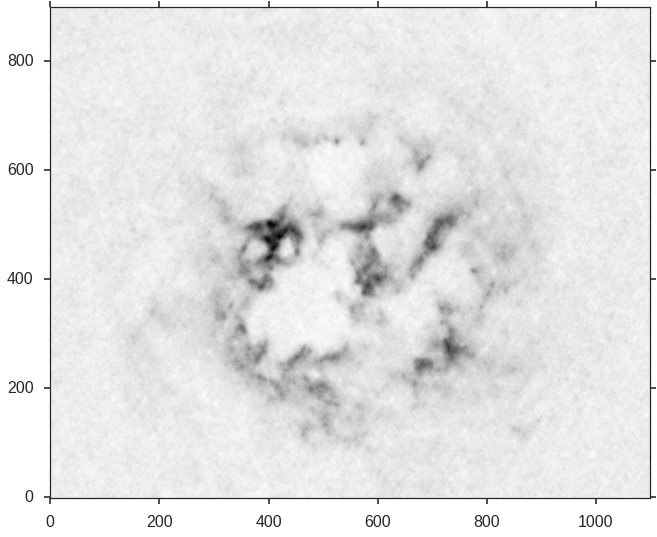

In [5]:
p.imshow(cube[15, :, :].value, origin='lower')

In [27]:
dask_chan15 = da.from_array(cube[15, :, :].value, (20, 20))

In [35]:
dask_bth15 = dask_chan15.map_overlap(lambda a: nd.black_tophat(a, size=20), 20).compute()

<matplotlib.colorbar.Colorbar instance at 0x7f34b7759878>

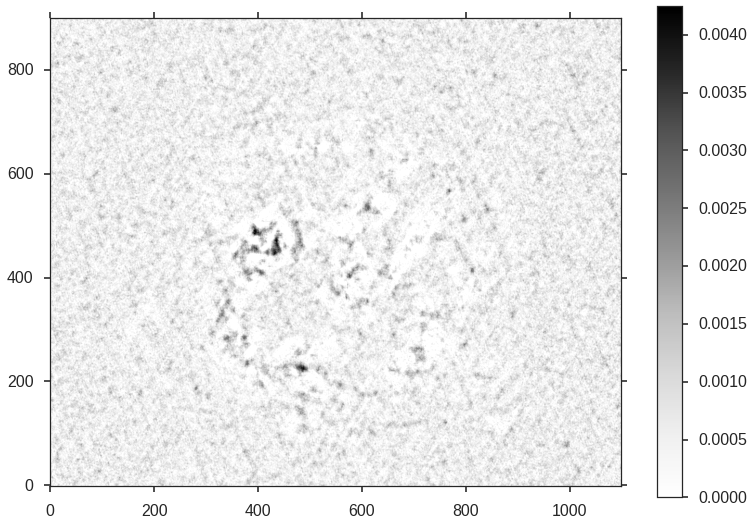

In [36]:
p.imshow(dask_bth15, origin='lower')
p.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f34bd411cf8>

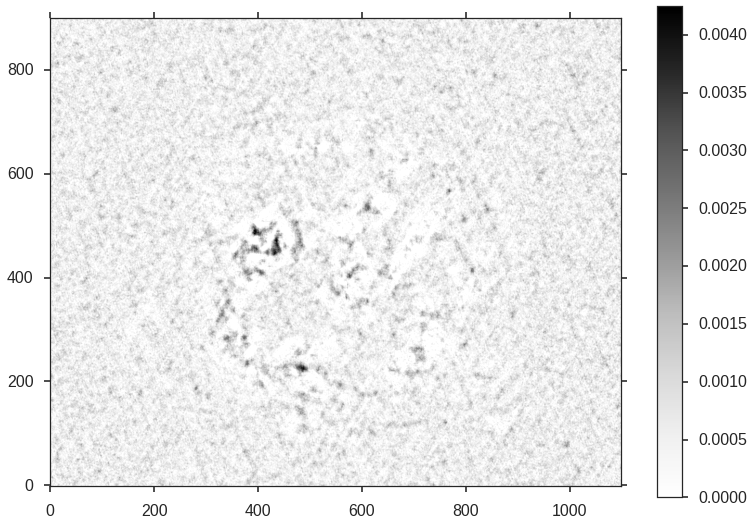

In [66]:
p.imshow(nd.black_tophat(cube[15, :, :].value, size=2nd.black_tophat(cube[15, :, :].value, size=20), origin='lower'0), origin='lower')
p.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f34baa61b90>

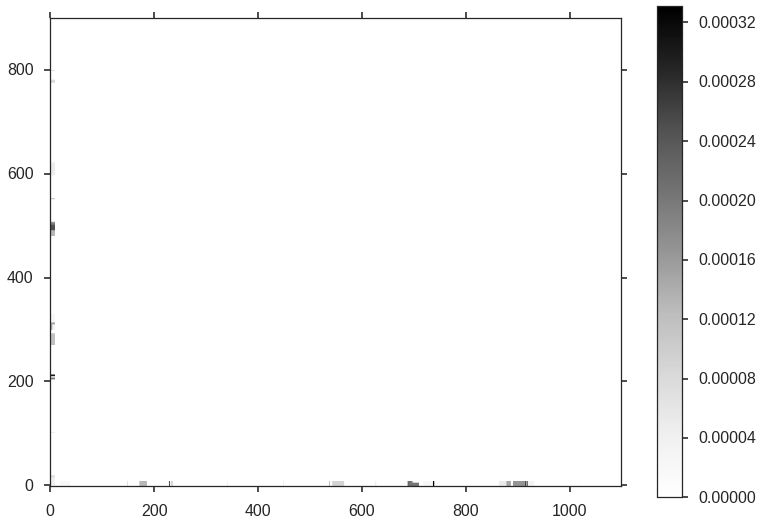

In [38]:
p.imshow(np.abs(nd.black_tophat(cube[15, :, :].value, size=20)-dask_bth15), origin='lower')
p.colorbar()

So the chunking works when the overlap is the same size of the kernel. There's a bit of minor artifacts along the edge, but that shouldn't really matter.

Now to test timing as we increase the size!

In [81]:
def dask_bth(array, size=None, block=None, structure=None):
    if block is None:
        dask_arr = da.from_array(array, (size, size))
    else:
        dask_arr = da.from_array(array, block)
    return dask_arr.map_overlap(lambda a: nd.black_tophat(a, size=size, structure=structure), size).compute()

In [73]:
for i in xrange(1, 10):
    if i == 1:
        scale_beam = cube.beam.as_tophat_kernel(get_pixel_scales(cube.wcs))
    else:
        scale_beam = Beam(major=cube.beam.major*i, minor=cube.beam.minor*i, pa=cube.beam.pa).as_tophat_kernel(get_pixel_scales(cube.wcs))
    struct = scale_beam.array > 0.0
    struct = struct.astype(int)
    # Remove empty space along the edges
    yposn, xposn = np.where(struct > 0)
    struct = \
        struct[np.min(yposn)-1:np.max(yposn)+2,
               np.min(xposn)-1:np.max(xposn)+2]
    print struct.shape
    %%timeit bth = nd.black_tophat(cube[15, :, :].value, structure=struct)

(11, 13)
1 loops, best of 3: 553 ms per loop
(19, 23)
1 loops, best of 3: 1.43 s per loop
(29, 33)
1 loops, best of 3: 3 s per loop
(37, 45)
1 loops, best of 3: 5.26 s per loop
(47, 55)
1 loops, best of 3: 8.3 s per loop
(55, 65)
1 loops, best of 3: 11.6 s per loop
(63, 75)
1 loops, best of 3: 15.2 s per loop
(73, 87)
1 loops, best of 3: 20.5 s per loop
(81, 97)
1 loops, best of 3: 25.6 s per loop


In [80]:
for i in xrange(1, 10):
    if i == 1:
        scale_beam = cube.beam.as_tophat_kernel(get_pixel_scales(cube.wcs))
    else:
        scale_beam = Beam(major=cube.beam.major*i, minor=cube.beam.minor*i, pa=cube.beam.pa).as_tophat_kernel(get_pixel_scales(cube.wcs))
    struct = scale_beam.array > 0.0
    struct = struct.astype(int)
    # Remove empty space along the edges
    yposn, xposn = np.where(struct > 0)
    struct = \
        struct[np.min(yposn)-1:np.max(yposn)+2,
               np.min(xposn)-1:np.max(xposn)+2]
    %%timeit bth = dask_bth(cube[15, :, :].value, size=100, structure=struct, block=(300, 275))

1 loops, best of 3: 494 ms per loop
1 loops, best of 3: 1.17 s per loop
1 loops, best of 3: 3.17 s per loop
1 loops, best of 3: 6.4 s per loop
1 loops, best of 3: 9.94 s per loop
1 loops, best of 3: 13.6 s per loop
1 loops, best of 3: 19 s per loop
1 loops, best of 3: 28.3 s per loop
1 loops, best of 3: 36.2 s per loop



This is from my flux recovery class (how much of the total flux was captured in the interferometric cube). It might need some tweaking, but was supposed to be generalized.

In [17]:
def auto_dask_map(cube, operation=convolve_fft, blocks=None, args=[],
                  kwargs={}, output_array=None, verbose=True):
    '''
    Based on the dimensions of the given cube, and the dimensions
    of the blocks, return an appropriate dask output.

    Currently, this only supports 2D and 3D inputs. For 2D blocks,
    an iterator is returned with 2D slices of the array. For 3D,
    a single dask array is returned.
    '''

    if len(blocks) == 2:

        if output_array is None:
            output_array = np.empty(cube.shape)

            def_slice = [slice(None)] * len(cube.shape)

        for chan, cube_slice in dask_slice_iterator(cube, blocks):
            if verbose:
                print("On "+str(chan))
            def_slice[0] = slice(chan, chan+1)
            output_array[def_slice] = \
                cube_slice.map_overlap(lambda a:
                                      operation(a, *args, **kwargs), 5).compute()

    else:
        dask_arr = da.from_array(cube.filled_data[:], blocks)

        if verbose:
            print("No channel iterations, so no print out.")

        # In the >2D case, map blocks to function in 2D planes

        output_array = \
            dask_arr.map_blocks(
                lambda a: _map_flatten(operation,
                                       a, args=args,
                                       kwargs=kwargs)).compute()

    return output_array

def dask_slice_iterator(cube, blocks):
    for chan in range(len(cube.spectral_axis)):
        yield chan, da.from_array(cube.filled_data[chan, :, :],
                                  blocks)

def _map_flatten(operation, arr, args=[], kwargs={}):

    restore_slice = [slice(None)] * len(arr.shape)

    for i in np.where(np.asarray(arr.shape)==1)[0]:
        restore_slice[i] = np.newaxis

    return operation(arr.squeeze(), *args, **kwargs)[restore_slice]

In [23]:
bth_test = auto_dask_map(cube, operation=nd.black_tophat, blocks=(10, 10), kwargs={"size": 10})

On 0
On 1
On 2
On 3
On 4
On 5
On 6
On 7
On 8
On 9
On 10
On 11
On 12
On 13
On 14
On 15
On 16
On 17
On 18
On 19
On 20
On 21
On 22
On 23
On 24
On 25
On 26


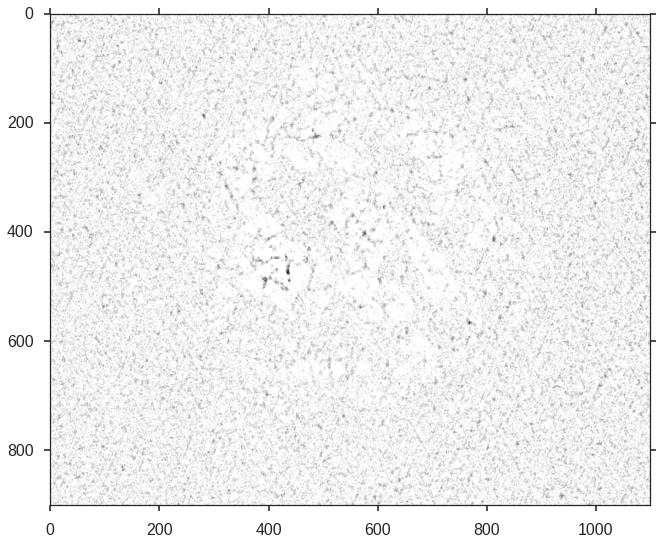

In [24]:
p.imshow(bth_test[15, :, :])

<matplotlib.colorbar.Colorbar instance at 0x7f34b8c6c128>

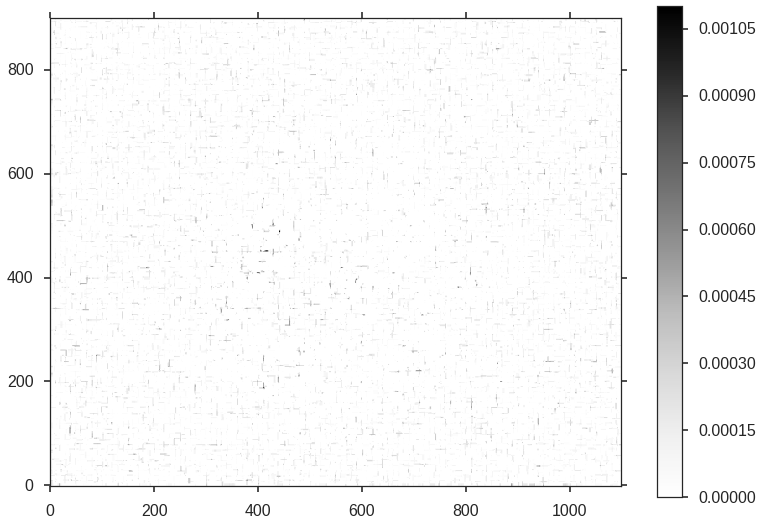

In [25]:
test_15 = nd.black_tophat(cube[15, :, :].value, size=10)
p.imshow(test_15 - bth_test[15, :, :], origin='lower')
p.colorbar()
